# Coding Test Staf AI Researcher PT Delameta Bilano

## 1. Load & Get Data and Libraries

In [1]:
import torch
import requests
import zipfile
import os
import matplotlib.pyplot as plt
import time
import numpy as np
from pathlib import Path
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
data_path = Path('data/')

if data_path.is_dir():
    print(f'{data_path} directory is exist!')
else:
    print(f'{data_path} directory not found. Try to create it first!')
    data_path.mkdir(parents=True, exist_ok=True)
        
    with zipfile.ZipFile('train.zip', 'r') as zip_train:
        zip_train.extractall(data_path)
        
    with zipfile.ZipFile('test.zip', 'r') as zip_test:
        zip_test.extractall(data_path)
    
os.remove('train.zip')
os.remove('test.zip')

data directory not found. Try to create it first!


## 2. Data Transformation and Preparation

In [3]:
train_dir = data_path / 'train'
test_dir = data_path / 'test'

train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

### 2.1 Data Augmentation

In [4]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225])
])

test_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225])
])

### 2.2 Dataset Preparation

In [5]:
train_data = datasets.ImageFolder(train_dir, 
                                  transform = train_transforms, 
                                  target_transform=None)

test_data = datasets.ImageFolder(test_dir, 
                                 transform = test_transforms)

len(train_data), len(test_data)

(2800, 200)

In [6]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
data_dict = train_data.class_to_idx
data_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
data_dict_inverse = {v:k for k, v in data_dict.items()}
data_dict_inverse

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### 2.3 Turn Dataset to Dataloader

In [9]:
train_dataloader = DataLoader(train_data, 
                              batch_size=32,
                              shuffle=True,
                              num_workers = 2,
                              pin_memory=True)

test_dataloader = DataLoader(test_data, 
                              batch_size=32,
                              shuffle=False,
                              num_workers = 2,
                              pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2b69c6d25e0>,
 <torch.utils.data.dataloader.DataLoader at 0x2b6c38365e0>)

### 2.4 Saving & Loading Datasets and Dataloaders

In [10]:
root_dir = 'data/'
torch.save(train_data, data_path / 'train_data.pkl')
torch.save(test_data, data_path / 'test_data.pkl')
torch.save(train_dataloader, data_path / 'train_dataloader.pkl')
torch.save(test_dataloader, data_path / 'test_dataloader.pkl')

In [11]:
train_data = torch.load(root_dir + 'train_data.pkl')
test_data = torch.load(root_dir + 'test_data.pkl')
train_dataloader = torch.load(root_dir + 'train_dataloader.pkl')
test_dataloader = torch.load(root_dir + 'test_dataloader.pkl')

In [12]:
train_data[0]

(tensor([[[-2.1179, -2.1179,  0.5364,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179,  0.4679,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179,  0.4679,  ...,  1.2214,  1.3242,  1.3242],
          ...,
          [-1.0733, -1.0904, -1.0390,  ..., -0.5424, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -0.7308, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -0.9705, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357,  0.6604,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357,  0.6604,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357,  0.6604,  ...,  1.3782,  1.4132,  1.3957],
          ...,
          [-1.0203, -1.0203, -1.0203,  ...,  0.2052, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -0.3025, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -0.7402, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044,  0.8622,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

### 2.5 Visualize Data Sample

<ipython-input-13-5e23f8b267a5>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  plt.imshow(image.T, cmap='gray')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, 'airplane')

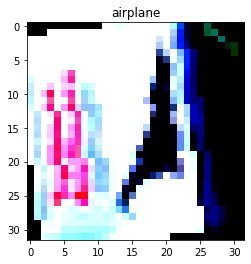

In [13]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.T, cmap='gray')
plt.title(class_names[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

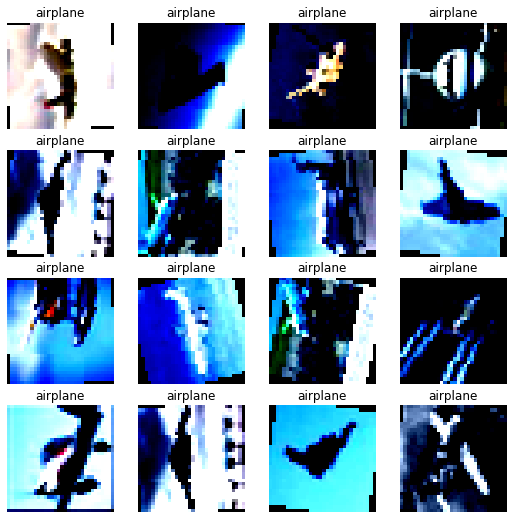

In [14]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.T, cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 3. Model Development and Training

### 3.1 CNN from Scratch (Baseline Model)  

In [15]:
import torch.nn as nn

class ClassifierModel(nn.Module):
    def __init__(self, input_shape: int, 
                 hidden_units: int, 
                 output_shape: int):
        
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
        )
    
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classsifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classsifier(x)
        return x

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = ClassifierModel(input_shape=3,
                        hidden_units=10,
                        output_shape=len(class_names))
model.to(device)
model

ClassifierModel(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classsifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)

### 3.2 Core Function for Training and Evaluation Model

In [17]:
def print_train_time(start, end, device):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device
              ):
    
    model.train()
    
    train_acc, train_loss = 0.0, 0.0
    
    for batch, (X, y) in enumerate(data_loader):
        
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)
        
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y_true= y, y_pred=y_logits.argmax(dim=1))
        
        train_loss += loss
        train_acc += acc
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
    train_acc /= len(data_loader)
    train_loss /= len(data_loader)
    
    return train_acc, train_loss

def test_step(model: torch.nn.Module,  
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    model.eval()
    
    test_acc, test_loss = 0.0, 0.0
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_logits = model(X)
            test_loss += loss_fn(test_logits, y)
            test_acc += accuracy_fn(y_true= y, y_pred=test_logits.argmax(dim=1))

        test_acc /= len(data_loader)
        test_loss /= len(data_loader)
    
    return test_acc, test_loss

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    eval_loss, eval_acc = 0.0, 0.0
    
    y_preds = []
    
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            eval_logits = model(X)
            eval_loss += loss_fn(eval_logits, y)
            eval_acc += accuracy_fn(y_true=y, y_pred=eval_logits.argmax(dim=1))
            
            y_pred = torch.softmax(eval_logits, dim=1).argmax(dim=1)
            y_preds.append(y_pred.cpu())
        
        eval_loss /= len(data_loader)
        eval_acc /= len(data_loader)
        
    
    final_results = {'model': model.__class__.__name__,
                     'eval loss': eval_loss.item(),
                     'eval acc': eval_acc
                    }
    
    y_pred_tensor = torch.cat(y_preds)
    
    
    return final_results, y_pred_tensor

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         accuracy_fn,
         epochs: int = 20,
         best_test_loss: int = 3):
    
    train_time_start = timer()

    torch.manual_seed(42)

    results = {
        'train_acc': [],
        'train_loss': [],
        'test_acc': [],
        'test_loss': [],
    }

    t0 = time.time()

    for epoch in tqdm(range(1, epochs + 1)):

        train_acc, train_loss = train_step(model=model,
                                            data_loader=train_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            accuracy_fn=accuracy_fn)

        test_acc, test_loss = test_step(model=model,
                                          data_loader=test_dataloader,
                                          loss_fn=loss_fn,
                                          accuracy_fn = accuracy_fn)

        print(f'Epoch: {epoch} | Accuracy: {train_acc:.4f} | Loss: {train_loss:.4f} | Val Accuracy: {test_acc:.4f} | Val Loss: {test_loss:.4f} | Time: {(time.time() - t0):.2f}s')

        results['train_acc'].append(train_acc)
        results['train_loss'].append(train_loss.item())
        results['test_acc'].append(test_acc)
        results['test_loss'].append(test_loss.item())
        
        saved_model_path = Path('models')
        
        if not saved_model_path.is_dir():
            saved_model_path.mkdir(parents=True, exist_ok=True)
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            print(f"\nSaving best model for epoch: {epoch}\n")
            
            torch.save(model.state_dict(), saved_model_path / 'best_model.pth')
    
    torch.save(model.state_dict(), saved_model_path / 'final_model.pth')
    
    train_time_end = timer()
    total_train_time_model = print_train_time(start=train_time_start,
                                                end=train_time_end,
                                                device=device)
    
    return model, results

def plot_acc_loss_curves(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    
def plot_cm(y_pred_tensor: np.ndarray):
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor, target=torch.tensor(test_data.targets))

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), 
        class_names=class_names,
        figsize=(10, 7))

### 3.3 Setting Hyperparameters

In [18]:
epochs = 30
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 3.4 Training Model 1 (CNN From Scratch)

In [19]:
model, results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       accuracy_fn=accuracy_fn,
                       epochs= epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Accuracy: 17.2585 | Loss: 2.2221 | Val Accuracy: 29.0179 | Val Loss: 1.9973 | Time: 25.90s

Saving best model for epoch: 1

Epoch: 2 | Accuracy: 28.6222 | Loss: 1.9977 | Val Accuracy: 33.0357 | Val Loss: 1.8857 | Time: 41.63s

Saving best model for epoch: 2

Epoch: 3 | Accuracy: 33.5582 | Loss: 1.8722 | Val Accuracy: 32.5893 | Val Loss: 1.7274 | Time: 58.62s

Saving best model for epoch: 3

Epoch: 4 | Accuracy: 38.1747 | Loss: 1.7391 | Val Accuracy: 36.6071 | Val Loss: 1.7798 | Time: 74.71s
Epoch: 5 | Accuracy: 39.4531 | Loss: 1.6950 | Val Accuracy: 40.6250 | Val Loss: 1.6272 | Time: 90.83s

Saving best model for epoch: 5

Epoch: 6 | Accuracy: 41.3707 | Loss: 1.6239 | Val Accuracy: 42.8571 | Val Loss: 1.6392 | Time: 106.81s
Epoch: 7 | Accuracy: 42.6491 | Loss: 1.6003 | Val Accuracy: 41.9643 | Val Loss: 1.5346 | Time: 122.72s

Saving best model for epoch: 7

Epoch: 8 | Accuracy: 45.0639 | Loss: 1.5535 | Val Accuracy: 46.4286 | Val Loss: 1.4762 | Time: 138.78s

Saving best mod

### 3.5 Plot Accuracy and Loss

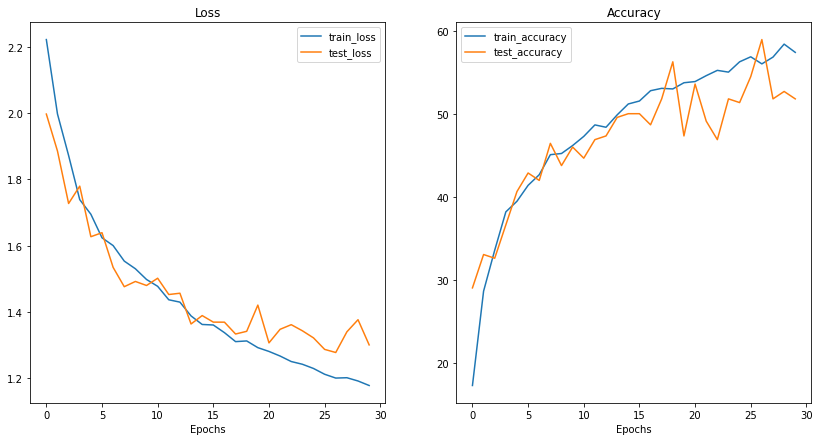

In [20]:
plot_acc_loss_curves(results)

## 4. Inference and Evaluate Model

### 4.1 Loading Best Saved Model

In [21]:
loaded_model = ClassifierModel(input_shape=3, 
                               hidden_units=10, 
                               output_shape=len(class_names)).to(device)
loaded_model.load_state_dict(torch.load('./models/best_model.pth'))

<All keys matched successfully>

### 4.2 Evaluate Model

In [22]:
model_results, model_preds = eval_model(model=loaded_model,
                                              data_loader=test_dataloader,
                                              loss_fn=loss_fn,
                                              accuracy_fn=accuracy_fn)
model_results

{'model': 'ClassifierModel',
 'eval loss': 1.277642846107483,
 'eval acc': 58.92857142857143}

### 4.3 Plot Confusion Matrix 

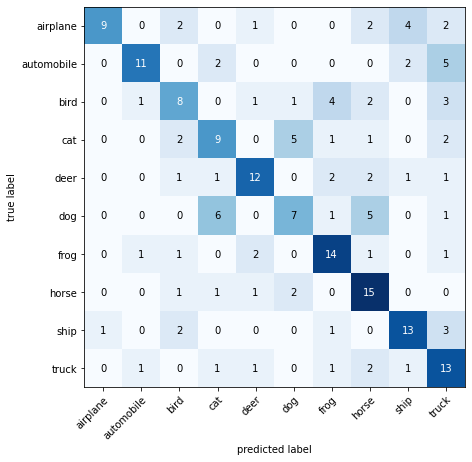

In [23]:
plot_cm(model_preds)

## 5. Export Model to Torchscript

In [24]:
example = torch.rand(1, 3, 32, 32)

In [25]:
traced_script_module = torch.jit.trace(loaded_model, example)

In [26]:
output = traced_script_module(torch.ones(1, 3, 32, 32))

In [27]:
output[0, :5]

tensor([-0.6335, -4.2068,  0.7270,  0.9059, -0.1733], grad_fn=<SliceBackward0>)

In [28]:
traced_script_module.save("models/traced_model.pt")